### Research Paper Referred Link:
##### Deep Convolutional Neural Networks and Data Augmentation for Environmental Sound Classification (https://arxiv.org/abs/1608.04363)

# Importing Libraries

In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
from random import shuffle
from keras import regularizers
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation, Dropout
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Directory Locations
input_dir = "./Datasets/ESC-10"
model_path="./Models/custom_sb_cnn.h5"

# Creating Functions for Preprocessing

In [3]:
def load_audio(filepath):
    """
    Description: Load audio file using librosa.
    Args:
        filepath (str): Path to the audio file.
    Returns:
        audio (np.ndarray): Audio signal.
        sr (int): Sampling rate.
    """
    audio, sr = librosa.load(filepath)
    return audio, sr

def load_data(input_dir):
    """
    Description: Load audio data and corresponding labels from the specified directory.
    Args:
        input_dir (str): Path to the directory containing audio files.
    Returns:
        data (np.ndarray): Loaded audio data.
        labels (np.ndarray): Corresponding labels.
    """
    data = []
    labels = []
    category_idx = {}
    for category_idx, category in enumerate(os.listdir(input_dir)):
        category_path = os.path.join(input_dir, category)
        for filename in os.listdir(category_path):
            filepath = os.path.join(category_path, filename)
            audio, sr = load_audio(filepath)
            features = extract_features(audio, sr)
            data.append(features.reshape(features.shape[0], features.shape[1], 1))
            labels.append(category_idx)
    data = np.array(data)
    labels = to_categorical(labels, num_classes=len(os.listdir(input_dir)))
    return data, labels

def extract_features(audio, sr):
    """
    Description: Extract audio features from the audio signal.
    Args:
        audio (np.ndarray): Audio signal.
        sr (int): Sampling rate.
    Returns:
        resized_spec (np.ndarray): Resized log-mel spectrogram.
    """
    stft = np.abs(librosa.stft(audio, hop_length=512, n_fft=2048))
    mel_spec = librosa.feature.melspectrogram(sr=sr, S=stft**2)
    log_mel_spec = librosa.amplitude_to_db(mel_spec, ref=np.max)
    resized_spec = np.zeros((128, 128))
    resized_spec[:min(128, log_mel_spec.shape[0]), :min(128, log_mel_spec.shape[1])] = log_mel_spec[:128, :128]
    return resized_spec


# Creating Functions for Model Training

In [4]:

def custom_model(data,output_shape):
    """
    Description: Build a custom CNN model.
    Args:
        data (np.ndarray): Input data.
        output_shape (int): Number of Classes
    Returns:
        model (tf.keras.Model): Built custom CNN model.
    """
    model = Sequential()
    model.add(Conv2D(24, (5, 5), strides=(1, 1), padding='valid', input_shape=data.shape[1:]))
    model.add(MaxPooling2D(pool_size=(4, 2), strides=(4, 2), padding='valid'))
    model.add(Activation('relu'))
    model.add(Conv2D(48, (5, 5), strides=(1, 1), padding='valid'))
    model.add(MaxPooling2D(pool_size=(4, 2), strides=(4, 2), padding='valid'))
    model.add(Activation('relu'))
    model.add(Conv2D(48, (5, 5), strides=(1, 1), padding='valid'))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(64,kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(output_shape,kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('softmax'))
    return model

def train_model(data, labels):
    """
    Description: Train the custom CNN model.
    Args:
        data (np.ndarray): Input data.
        labels (np.ndarray): Input labels.
    Returns:
        model (tf.keras.Model): Trained custom CNN model.
    """
    indices = list(range(len(data)))
    shuffle(indices)
    data = data[indices]
    labels = labels[indices]

    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
    
    model=custom_model(data,output_shape=len(labels[0]))
    checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')
    
    opt = tf.keras.optimizers.SGD(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history=model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2,callbacks=[checkpoint])
    
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    loss, accuracy = model.evaluate(X_test, y_test)
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)


# Creating Pipelines for Training and Prediction

In [5]:
def pipeline_train():
    """
    Description: Perform the training pipeline.
    Args:
        None
    Returns:
        None
    """
    data, labels = load_data(input_dir)
    train_model(data, labels)

In [6]:
def pipeline_predict(filepath):
    """
    Description: Perform the prediction pipeline for a given audio file.
    Args:
        filepath (str): Path to the audio file.
    Returns:
        class_label (str): Predicted class label.
    """
    model = load_model(model_path)
    audio, sr = load_audio(filepath)
    features = extract_features(audio, sr)
    features = features.reshape(1, features.shape[0], features.shape[1], 1)
    probs = model.predict(features)[0]
    class_index = np.argmax(probs)
    class_label = os.listdir(input_dir)[class_index]
    return class_label

# Running Training and Sample Testing

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 5.5775 - accuracy: 0.0977
Epoch 1: val_accuracy improved from -inf to 0.14062, saving model to ./Models\custom_sb_cnn.h5
8/8 [==============================] - 2s 141ms/step - loss: 5.5775 - accuracy: 0.0977 - val_loss: 2.9497 - val_accuracy: 0.1406
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 2.7888 - accuracy: 0.0938
Epoch 2: val_accuracy did not improve from 0.14062
8/8 [==============================] - 1s 127ms/step - loss: 2.7888 - accuracy: 0.0938 - val_loss: 2.4360 - val_accuracy: 0.0781
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 2.4241 - accuracy: 0.1328
Epoch 3: val_accuracy improved from 0.14062 to 0.17188, saving model to ./Models\custom_sb_cnn.h5
8/8 [==============================] - 1s 130ms/step - loss: 2.4241 - accuracy: 0.1328 - val_loss: 2.4497 - val_accuracy: 0.1719
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 2.4712 - accuracy: 0.12

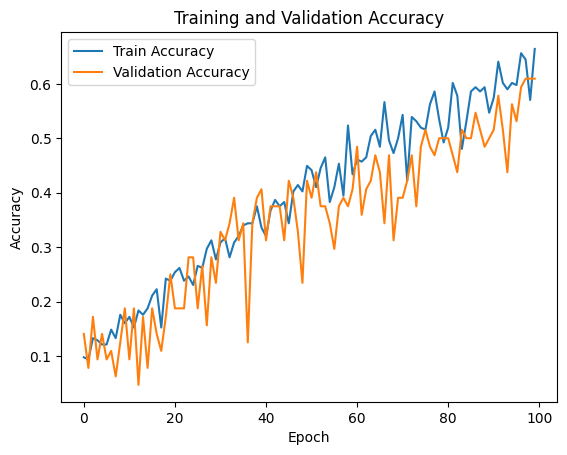

3/3 [==============================] - 0s 19ms/step - loss: 1.3844 - accuracy: 0.6000
Test loss: 1.3844213485717773
Test accuracy: 0.6000000238418579
Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 6.3612 - accuracy: 0.1328
Epoch 1: val_accuracy improved from -inf to 0.06250, saving model to ./Models\custom_sb_cnn.h5
8/8 [==============================] - 2s 153ms/step - loss: 6.3612 - accuracy: 0.1328 - val_loss: 2.4710 - val_accuracy: 0.0625
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 2.4577 - accuracy: 0.1406
Epoch 2: val_accuracy improved from 0.06250 to 0.17188, saving model to ./Models\custom_sb_cnn.h5
8/8 [==============================] - 1s 115ms/step - loss: 2.4577 - accuracy: 0.1406 - val_loss: 2.4070 - val_accuracy: 0.1719
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 2.4103 - accuracy: 0.1328
Epoch 3: val_accuracy improved from 0.17188 to 0.23438, saving model to ./Models\custom_sb_cnn.h5
8/8 [=================

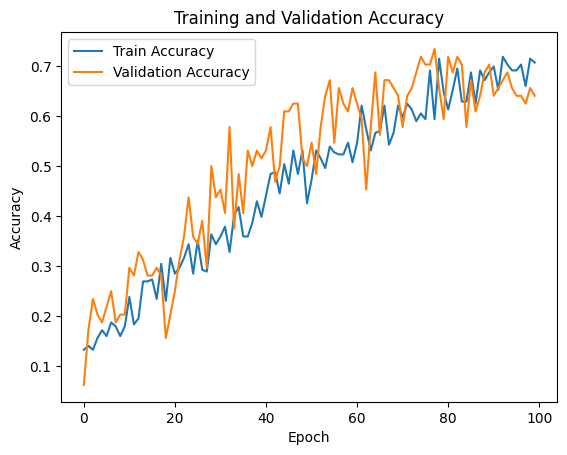

3/3 [==============================] - 0s 28ms/step - loss: 1.3160 - accuracy: 0.5750
Test loss: 1.316016435623169
Test accuracy: 0.574999988079071
Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 5.3260 - accuracy: 0.0859
Epoch 1: val_accuracy improved from -inf to 0.09375, saving model to ./Models\custom_sb_cnn.h5
8/8 [==============================] - 1s 130ms/step - loss: 5.3260 - accuracy: 0.0859 - val_loss: 2.4953 - val_accuracy: 0.0938
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 2.5019 - accuracy: 0.1133
Epoch 2: val_accuracy did not improve from 0.09375
8/8 [==============================] - 1s 120ms/step - loss: 2.5019 - accuracy: 0.1133 - val_loss: 2.4306 - val_accuracy: 0.0781
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 2.4453 - accuracy: 0.1328
Epoch 3: val_accuracy did not improve from 0.09375
8/8 [==============================] - 1s 119ms/step - loss: 2.4453 - accuracy: 0.1328 - val_loss: 2.4135 - val_accura

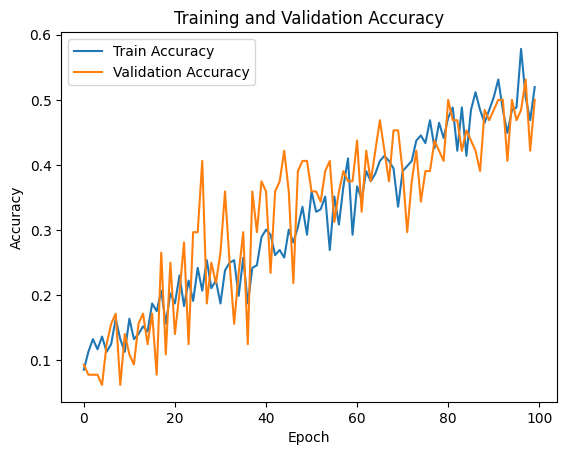

3/3 [==============================] - 0s 21ms/step - loss: 1.5573 - accuracy: 0.5625
Test loss: 1.5573203563690186
Test accuracy: 0.5625
Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 5.9985 - accuracy: 0.1016
Epoch 1: val_accuracy improved from -inf to 0.07812, saving model to ./Models\custom_sb_cnn.h5
8/8 [==============================] - 1s 129ms/step - loss: 5.9985 - accuracy: 0.1016 - val_loss: 2.6111 - val_accuracy: 0.0781
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 2.4932 - accuracy: 0.1055
Epoch 2: val_accuracy improved from 0.07812 to 0.14062, saving model to ./Models\custom_sb_cnn.h5
8/8 [==============================] - 1s 126ms/step - loss: 2.4932 - accuracy: 0.1055 - val_loss: 2.4043 - val_accuracy: 0.1406
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 2.4439 - accuracy: 0.0977
Epoch 3: val_accuracy did not improve from 0.14062
8/8 [==============================] - 1s 124ms/step - loss: 2.4439 - accuracy: 0

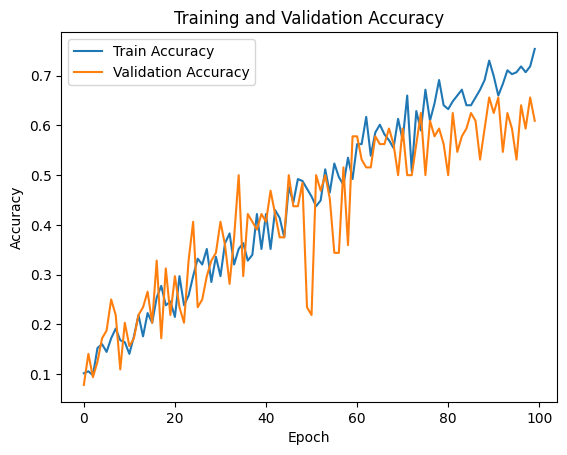

3/3 [==============================] - 0s 23ms/step - loss: 1.4226 - accuracy: 0.5375
Test loss: 1.422628402709961
Test accuracy: 0.5375000238418579
Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 6.2758 - accuracy: 0.0898
Epoch 1: val_accuracy improved from -inf to 0.10938, saving model to ./Models\custom_sb_cnn.h5
8/8 [==============================] - 1s 139ms/step - loss: 6.2758 - accuracy: 0.0898 - val_loss: 2.4622 - val_accuracy: 0.1094
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 2.4601 - accuracy: 0.1211
Epoch 2: val_accuracy did not improve from 0.10938
8/8 [==============================] - 1s 118ms/step - loss: 2.4601 - accuracy: 0.1211 - val_loss: 2.4412 - val_accuracy: 0.0938
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 2.4432 - accuracy: 0.1602
Epoch 3: val_accuracy did not improve from 0.10938
8/8 [==============================] - 1s 118ms/step - loss: 2.4432 - accuracy: 0.1602 - val_loss: 2.4772 - val_accur

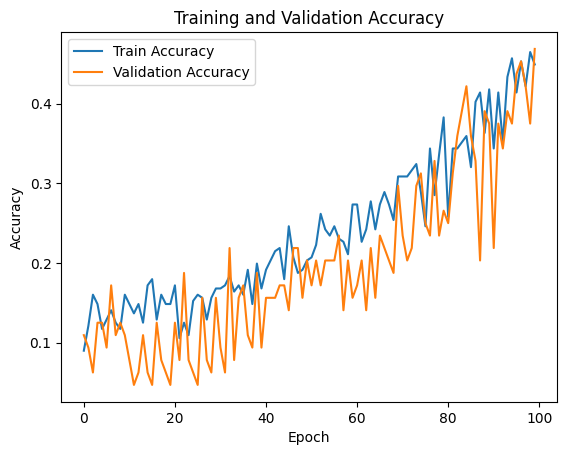

3/3 [==============================] - 0s 24ms/step - loss: 1.8129 - accuracy: 0.5125
Test loss: 1.8128513097763062
Test accuracy: 0.512499988079071
Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 5.3617 - accuracy: 0.1055
Epoch 1: val_accuracy improved from -inf to 0.09375, saving model to ./Models\custom_sb_cnn.h5
8/8 [==============================] - 1s 137ms/step - loss: 5.3617 - accuracy: 0.1055 - val_loss: 2.4932 - val_accuracy: 0.0938
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 2.4884 - accuracy: 0.0938
Epoch 2: val_accuracy improved from 0.09375 to 0.10938, saving model to ./Models\custom_sb_cnn.h5
8/8 [==============================] - 1s 124ms/step - loss: 2.4884 - accuracy: 0.0938 - val_loss: 2.4247 - val_accuracy: 0.1094
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 2.4297 - accuracy: 0.1328
Epoch 3: val_accuracy did not improve from 0.10938
8/8 [==============================] - 1s 123ms/step - loss: 2.4297 - 

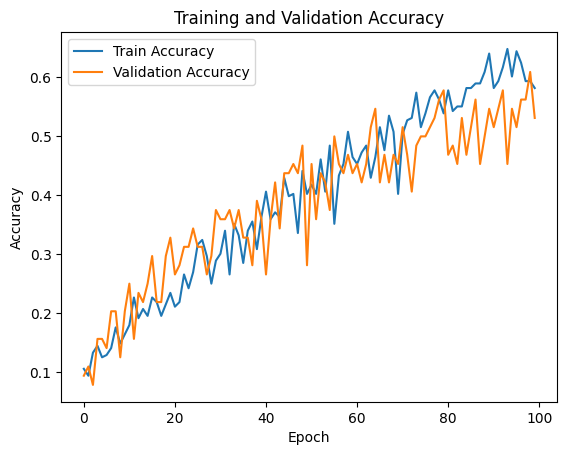

3/3 [==============================] - 0s 22ms/step - loss: 1.4153 - accuracy: 0.5625
Test loss: 1.4153318405151367
Test accuracy: 0.5625
Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 6.0835 - accuracy: 0.0781
Epoch 1: val_accuracy improved from -inf to 0.15625, saving model to ./Models\custom_sb_cnn.h5
8/8 [==============================] - 1s 135ms/step - loss: 6.0835 - accuracy: 0.0781 - val_loss: 2.4287 - val_accuracy: 0.1562
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 2.5101 - accuracy: 0.0938
Epoch 2: val_accuracy did not improve from 0.15625
8/8 [==============================] - 1s 122ms/step - loss: 2.5101 - accuracy: 0.0938 - val_loss: 2.5854 - val_accuracy: 0.1094
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 2.5226 - accuracy: 0.1211
Epoch 3: val_accuracy did not improve from 0.15625
8/8 [==============================] - 1s 121ms/step - loss: 2.5226 - accuracy: 0.1211 - val_loss: 2.4168 - val_accuracy: 0.1562

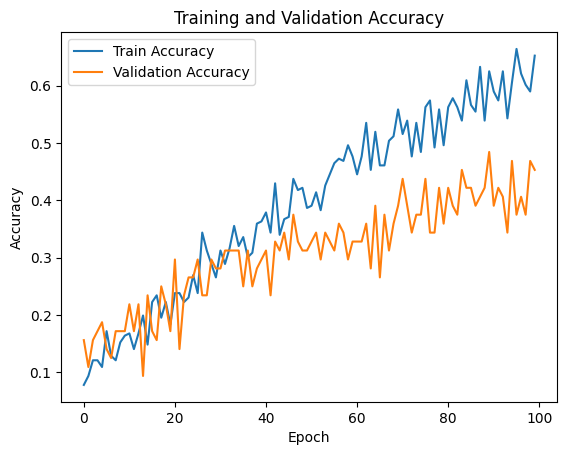

3/3 [==============================] - 0s 21ms/step - loss: 1.5747 - accuracy: 0.5375
Test loss: 1.5746543407440186
Test accuracy: 0.5375000238418579
1min 40s ± 1.18 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%timeit -n1 pipeline_train()

In [8]:
# pipeline_predict(r'./Datasets/ESC-10/003 - Sea waves/1-28135-A.ogg')